# Spatial Queries

In spatial analysis, our goal is not just to make nice maps, but to actually run analyses that leverage the explicitly spatial nature of our data. The process of doing this is known as **spatial analysis**.

To construct spatial analyses, we string together series of spatial operations in such a way that the end result answers our question of interest. There are many such spatial operations. These are known as **spatial queries**.

These queries can be divided into:

- **Measurement queries**
    - What is feature A's **length**?
    - What is feature A's **area**?
    - What is feature A's **perimeter**?
    - What is feature A's **distance** from feature B?
- **Relationship queries**
    - Is feature A **within** feature B?
    - Does feature A **intersect** with feature B?
    - Does feature A **cross** feature B?
    
Spatial queries are not limited to the examples we've shown here.

We'll work through examples of each of those types of queries. Then, we'll see an example of a very common spatial analysis that is a conceptual amalgam of those two types: **proximity analysis**.

<!--
- Expected time to complete
    - Lecture + Questions: 45 minutes
    - Exercises: 20 minutes
-->

In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline  

## Load and Prep Some Data

Let's read in our Census tracts data again:

<Axes: >

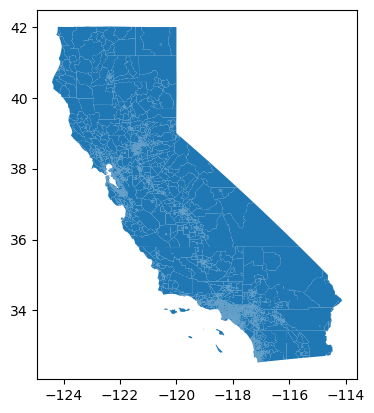

In [2]:
census_tracts = gpd.read_file("zip://../data/census/Tracts/cb_2013_06_tract_500k.zip")
census_tracts.plot()

In [3]:
census_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,06,001,400300,1400000US06001400300,06001400300,4003,CT,1105329,0,"POLYGON ((-122.26416 37.84000, -122.26186 37.8..."
1,06,001,400900,1400000US06001400900,06001400900,4009,CT,420877,0,"POLYGON ((-122.28558 37.83978, -122.28319 37.8..."
2,06,001,402200,1400000US06001402200,06001402200,4022,CT,712082,0,"POLYGON ((-122.30403 37.80739, -122.30239 37.8..."
3,06,001,402800,1400000US06001402800,06001402800,4028,CT,398311,0,"POLYGON ((-122.27598 37.80622, -122.27335 37.8..."
4,06,001,404800,1400000US06001404800,06001404800,4048,CT,628405,0,"POLYGON ((-122.21825 37.80086, -122.21582 37.8..."


Then, we'll grab just the Alameda Country tracts.

<Axes: >

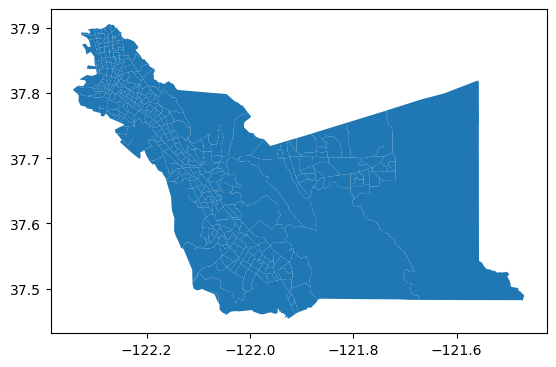

In [4]:
census_tracts_ac = census_tracts.loc[census_tracts['COUNTYFP'] == '001'].reset_index(drop=True)
census_tracts_ac.plot()

## Measurement Queries

We'll start off with some simple measurement queries.

For example, here's how we can get the areas of each of our Census tracts:

In [5]:
census_tracts_ac.area

/var/folders/sy/_bbz4lwx7j79hkfq676xt87m0000gn/T/ipykernel_39360/3288917862.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_tracts_ac.area


0      0.000113
1      0.000045
2      0.000071
3      0.000041
4      0.000063
         ...   
356    0.000098
357    0.002275
358    0.000033
359    0.000139
360    0.000316
Length: 361, dtype: float64

Okay! We got...numbers?

What do those numbers mean? What are our units? And if we're not sure, how might be find out?

Let's take a look at our CRS:

In [6]:
census_tracts_ac.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

Ah-ha! We're working in an unprojected CRS, with units of decimal degrees.

**When doing spatial analysis, we will almost always want to work in a projected CRS that has natural distance units, such as meters!**

Time to project!

As previously, we'll use UTM Zone 10N with a NAD83 data. This is a good choice for our region of interest.

In [7]:
census_tracts_ac_utm10 = census_tracts_ac.to_crs("epsg:26910")

In [8]:
census_tracts_ac_utm10.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Now, let's try our area calculation again.

In [9]:
census_tracts_ac_utm10.area

0      1.105797e+06
1      4.355184e+05
2      6.930523e+05
3      4.003615e+05
4      6.183936e+05
           ...     
356    9.653980e+05
357    2.230584e+07
358    3.197167e+05
359    1.355161e+06
360    3.087534e+06
Length: 361, dtype: float64

That looks much more reasonable! What are our units, now?

You may have noticed that our Census tracts already have an area column in them.

Let's do a confidence check on our results.

In [10]:
# Calculate the area for the 0th feature
census_tracts_ac_utm10.area[0]

1105796.6056938667

In [11]:
# Get the area for the 0th feature according to its 'ALAND' attribute
census_tracts['ALAND'][0]

1105329

In [12]:
# Check equivalence of the calculated areas and the 'ALAND' column
census_tracts_ac_utm10['ALAND'].values == census_tracts_ac_utm10.area

0      False
1      False
2      False
3      False
4      False
       ...  
356    False
357    False
358    False
359    False
360    False
Length: 361, dtype: bool

What explains this disagreement? Are the calculated areas incorrect?

We can also sum the area for Alameda county by adding `.sum()` to the end of our area calculation:

In [13]:
census_tracts_ac_utm10.area.sum()

1948917581.1122937

We can actually look up how large Alameda County is to check our work. The county is 739 miles<sup>2</sup>, which is around 1,914,001,213 meters<sup>2</sup>. I'd say we're pretty close!

As it turns out, we can similarly use another attribute to get the features' lengths.

**NOTE**: In this case, given we're dealing with polygons, this is equivalent to getting the features' perimeters.

In [14]:
census_tracts_ac_utm10.length

0       5357.060239
1       2756.937555
2       5395.895162
3       2681.974829
4       3710.388859
           ...     
356     4331.600289
357    32004.773556
358     2353.624225
359     4718.701537
360     8176.643793
Length: 361, dtype: float64

## Relationship Queries

[Spatial relationship queries](https://en.wikipedia.org/wiki/Spatial_relation) consider how two geometries or sets of geometries relate to one another in space. 

<img src="https://upload.wikimedia.org/wikipedia/commons/5/55/TopologicSpatialRelarions2.png" height="300px"></img>

Here is a list of the most commonly used GeoPandas methods to test spatial relationships:

- [within](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.within)
- [contains](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.contains) (the inverse of `within`)
- [intersects](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.intersects)

There several other GeoPandas spatial relationship predicates, but they are more complex to properly employ. For example, the following two operations only work with geometries that are completely aligned.

- [touches](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.touches)
- [equals](http://geopandas.org/reference.html?highlight=distance#geopandas.GeoSeries.equals)

All of these methods takes the form:

    Geoseries.<predicate>(geometry)
    
For example:

    Geoseries.contains(geometry)

Let's load a new dataset to demonstrate these queries.

This is a dataset containing all the protected areas (parks and the like) in California.

In [15]:
parks = gpd.read_file('../data/protected_areas/CPAD_2020a_Units.shp')

Does this need to be reprojected too?

In [16]:
parks.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Yes it does!

Let's reproject it.

In [17]:
parks_utm10 = parks.to_crs("epsg:26910")

One common use for spatial queries is for spatial subsetting of data.

In our case, let's use `intersects` to find all of the parks that have land in Alameda County.

But before we do that, let's take another look at our geometries.

In [18]:
census_tracts_ac_utm10.geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

<Axes: >

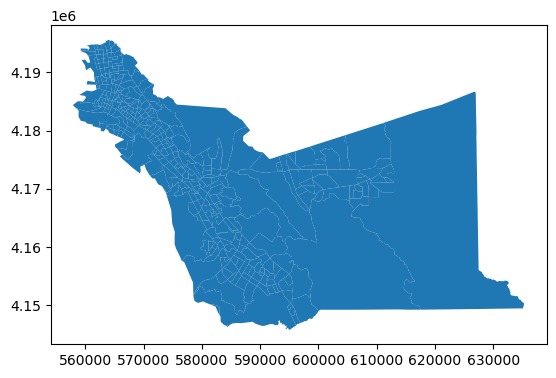

In [19]:
census_tracts_ac_utm10.plot()

Because we nave Census tracts, each of these rows is either a Polygon or a MultiPolygon. For our relationship query, we can actually simplify our geometry to be one polygon by using `unary_union`:

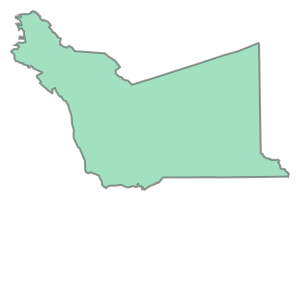

In [20]:
census_tracts_ac_utm10.geometry.unary_union

In [21]:
print(census_tracts_ac_utm10.geometry.unary_union)

POLYGON ((563465.766950718 4180333.9558535228, 563424.7710989327 4180272.7467862284, 563146.2572290965 4179856.9403916523, 562622.2535775516 4179936.269532985, 562639.6411180868 4180395.094790428, 562405.5354482827 4180458.327306503, 561213.2460163363 4180780.485788293, 561263.4688464853 4181038.2770599783, 560289.009422765 4181211.3900929047, 559977.300439183 4181517.9041495207, 559214.0567447273 4181690.366204505, 559174.931213391 4181699.209083608, 558811.6496349227 4182388.413905217, 558813.5430202782 4182477.0819199723, 558833.1875988517 4183397.228530629, 558484.6105058471 4183794.184878632, 558392.3277898125 4183870.4144159956, 557923.1624590305 4184258.0030732974, 557900.8913141483 4184445.3614872047, 558613.1964502601 4184981.5341004143, 558742.8183028696 4185079.1184984995, 559571.0131709152 4184978.1125482237, 560089.184817855 4185648.618488229, 559919.498338285 4185959.944915256, 558935.098301959 4186119.4876417615, 560184.7536923207 4186878.3839065987, 561064.384156118 418

Now, we can go ahead and conduct our operation `intersects`:

In [22]:
parks_in_ac = parks_utm10.intersects(census_tracts_ac_utm10.geometry.unary_union)

If we scroll the resulting GeoDataFrame to the right, we'll see that the `COUNTY` column of our resulting subset gives us a good confidence check on our results.

In [23]:
parks_in_ac

0        False
1        False
2        False
3        False
4        False
         ...  
17063    False
17064    False
17065    False
17066    False
17067    False
Length: 17068, dtype: bool

In [24]:
parks_utm10[parks_in_ac].head()

,ACCESS_TYP,UNIT_ID,UNIT_NAME,SUID_NMA,AGNCY_ID,AGNCY_NAME,AGNCY_LEV,AGNCY_TYP,AGNCY_WEB,LAYER,...,MNG_AG_LEV,MNG_AG_TYP,PARK_URL,COUNTY,ACRES,LABEL_NAME,YR_EST,DES_TP,GAP_STS,geometry
63,Open Access,185,Augustin Bernal Park,8732,1257,"Pleasanton, City of",City,City Agency,http://www.cityofpleasantonca.gov/,City,...,City,City Agency,http://www.cityofpleasantonca.gov/services/rec...,Alameda,217.388,Augustin Bernal Park,0.0,Local Park,4,"POLYGON ((595746.574 4165882.573, 595740.013 4..."
145,Open Access,366,San Antonio Park,24832,1228,"Oakland, City of",City,City Agency,http://www2.oaklandnet.com/Government/o/opr/in...,City,...,City,City Agency,NaN,Alameda,10.619,San Antonio Park,0.0,Local Park,4,"POLYGON ((566704.422 4182789.292, 566827.750 4..."
217,Open Access,586,Quarry Lakes Regional Recreation Area,30594,2032,East Bay Regional Park District,Special District,Recreation/Parks District,http://www.ebparks.org/,Special District,...,Special District,Recreation/Parks District,NaN,Alameda,254.616,Quarry Lakes Reg. Rec. Area,2001.0,Local Recreation Area,4,"MULTIPOLYGON (((588060.979 4158338.499, 587843..."
393,Open Access,1438,Tennis & Community Park,26243,1257,"Pleasanton, City of",City,City Agency,http://www.cityofpleasantonca.gov/,City,...,City,City Agency,NaN,Alameda,15.595,Tennis & Community Park,0.0,Local Park,4,"POLYGON ((596761.389 4170334.335, 597109.868 4..."
408,Open Access,48353,Sean Diamond Park,32917,1090,"Dublin, City of",City,City Agency,http://www.ci.dublin.ca.us/index.aspx?nid=1458,City,...,City,City Agency,https://www.dublin.ca.gov/Facilities/Facility/...,Alameda,4.986,Sean Diamond Park,2018.0,Local Park,4,"POLYGON ((601693.284 4175288.100, 601695.836 4..."


So does this overlay plot!

Text(0.5, 1.0, 'Protected areas in Alameda County, colored by area')

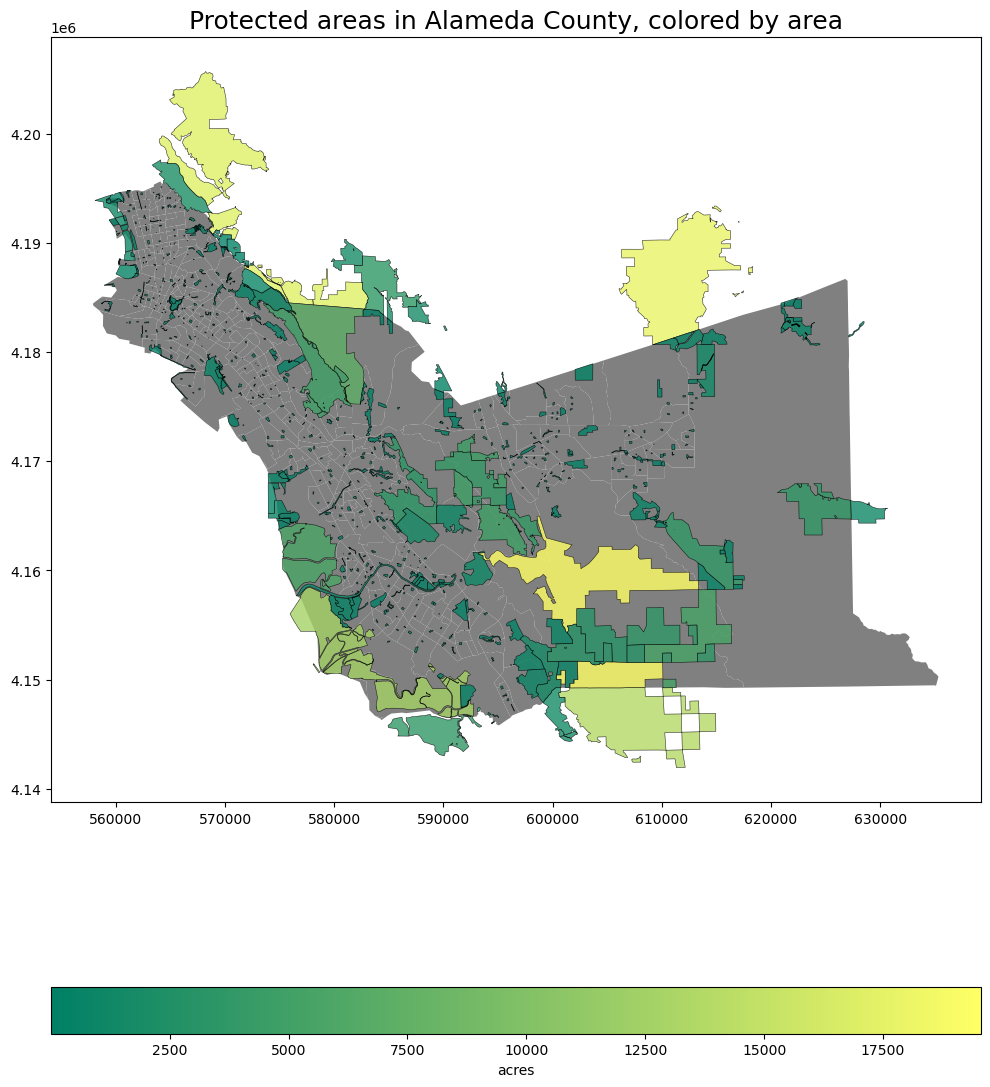

In [25]:
# Plot Census tracts
ax = census_tracts_ac_utm10.plot(color='gray', figsize=(12, 16))
# Plot parks
parks_utm10[parks_in_ac].plot(ax=ax,
                              column='ACRES',
                              cmap='summer',
                              legend=True,
                              edgecolor='black',
                              linewidth=0.4, 
                              alpha=0.8,
                              legend_kwds={'label': "acres", 'orientation': "horizontal"})
ax.set_title('Protected areas in Alameda County, colored by area', size=18)

---

### Challenge 1: Spatial Relationship Query

Let's use a spatial relationship query to create a new dataset containing Berkeley schools!

Run the next two cells to load datasets containing Berkeley's city boundary and Alameda County's
schools and to reproject them to EPSG: 26910.

Then in the following cell, write your own code to:

1. Subset the schools for only those `within` Berkeley.
2. Plot the Berkeley boundary and then the schools as an overlay map.

---

In [26]:
# Load the Berkeley boundary
berkeley = gpd.read_file("../data/berkeley/BerkeleyCityLimits.shp")
# Transform to EPSG:26910
berkeley_utm10 = berkeley.to_crs("epsg:26910")
# Look at GeoDataFrame
berkeley_utm10.head()

,CNTY_FIPS,geometry
0,001,"POLYGON ((564127.982 4195462.653, 564144.101 4..."


In [27]:
# Load the Alameda County schools CSV
schools_df = pd.read_csv('../data/alco_schools.csv')
# Convert it to a GeoDataFrame
schools_gdf = gpd.GeoDataFrame(schools_df, 
                               geometry=gpd.points_from_xy(schools_df.X, schools_df.Y))
# Define its unprojected (EPSG:4326) CRS
schools_gdf.crs = "epsg:4326"
# Transform to EPSG:26910
schools_gdf_utm10 = schools_gdf.to_crs("epsg:26910")
# Look at GeoDataFrame
schools_df.head()

,X,Y,Site,Address,City,State,Type,API,Org
0,-122.238761,37.744764,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public
1,-122.251856,37.738999,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public
2,-122.258915,37.762058,Donald D. Lum Elementary,1801 Sandcreek Way,Alameda,CA,ES,853,Public
3,-122.234841,37.765250,Edison Elementary,2700 Buena Vista Ave,Alameda,CA,ES,927,Public
4,-122.238078,37.753964,Frank Otis Elementary,3010 Fillmore St,Alameda,CA,ES,894,Public


In [28]:
# YOUR CODE HERE
# 1. Subset the schools for only those within Berkeley.
# Schools in Berkeley
schools_in_berkeley = schools_gdf_utm10.within(berkeley_utm10.geometry.squeeze())
# Now subsetting Berkeley-only schools
berkeley_only_schools = schools_gdf_utm10[schools_in_berkeley]


<Axes: >

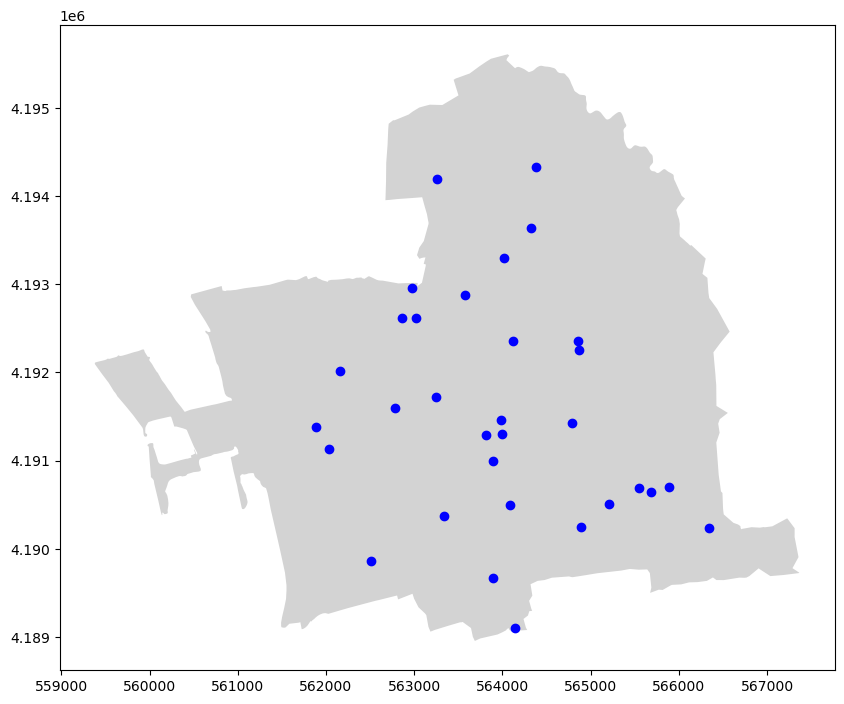

In [31]:
# YOUR CODE HERE
# 2. Plot the Berkeley boundary and then the schools as an overlay map.
# Create fig
fig, ax = plt.subplots(figsize=(10, 10))
# Plot Berkeley border
berkeley_utm10.plot(color='lightgrey', ax=ax)
# Plot Berkeley schools
berkeley_only_schools.plot(color='blue', ax=ax)

## Proximity Analysis

Now that we've seen the basic idea of spatial measurement and relationship queries, let's take a look at a common analysis that combines those concepts: **promximity analysis**.

Proximity analysis seeks to identify all features in a focal feature set that are within some maximum distance of features in a reference feature set.

A common workflow for this analysis is:

1. Buffer (i.e. add a margin around) the reference dataset, out to the maximum distance.
2. Run a spatial relationship query to find all focal features that intersect (or are within) the buffer.

Let's read in our bike boulevard data again. We'll find out which of our Berkeley schools are within a block's distance (200 m) of the boulevards.

<Axes: >

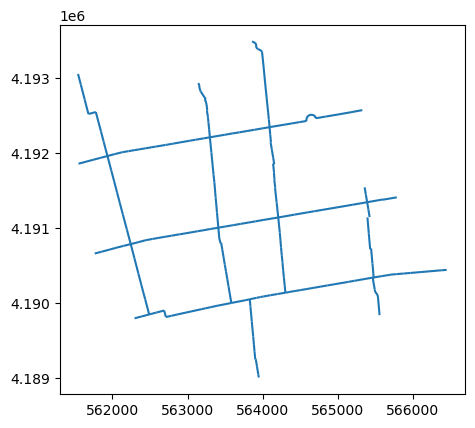

In [32]:
bike_blvds = gpd.read_file('../data/transportation/BerkeleyBikeBlvds.geojson')
bike_blvds.plot()

Of course, we need to reproject the boulevards to our projected CRS.

In [33]:
bike_blvds_utm10 = bike_blvds.to_crs("epsg:26910")

Now we can create our 200 meter bike boulevard buffers.

In [34]:
bike_blvds_utm10.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [35]:
bike_blvds_buf = bike_blvds_utm10.buffer(distance=200)

In [36]:
bike_blvds_buf.head()

0    POLYGON ((562340.415 4190014.301, 562359.613 4...
1    POLYGON ((562437.888 4190040.076, 562457.087 4...
2    POLYGON ((562534.542 4190065.662, 562553.739 4...
3    POLYGON ((562638.297 4190092.771, 562657.507 4...
4    POLYGON ((562904.953 4189862.893, 562908.952 4...
dtype: geometry

Now, let's overlay everything.

<Axes: >

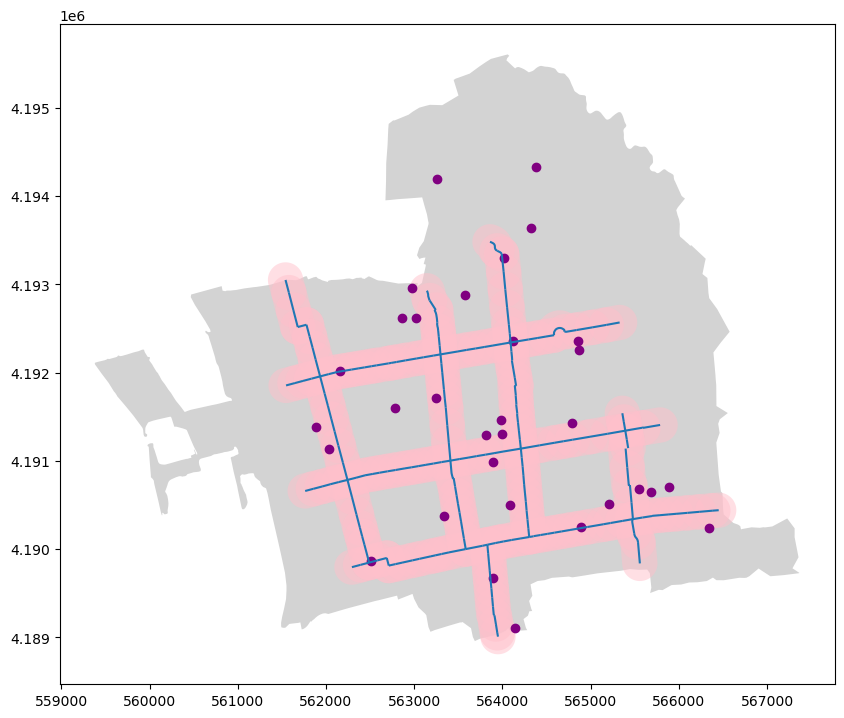

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
# Plot Berkeley city boundary
berkeley_utm10.plot(color='lightgrey', ax=ax)
# Plot buffer
bike_blvds_buf.plot(color='pink', ax=ax, alpha=0.5)
# Plot bicycle boulevards
bike_blvds_utm10.plot(ax=ax)
# Plot Berkeley schools
berkeley_schools = berkeley_only_schools
berkeley_only_schools.plot(color='purple',ax=ax)

Great! Looks like we're all ready to run our intersection to complete the proximity analysis.

**NOTE**: In order to subset with our buffers, we need to call the `unary_union` attribute of the buffer object. This gives us a single unified polygon, rather than a series of multipolygons representing buffers around each of the points in our multilines.

In [41]:
schools_near_blvds = berkeley_schools.within(bike_blvds_buf.unary_union)
blvd_schools = berkeley_schools[schools_near_blvds]

Now let's overlay again, to see if the schools we subsetted make sense.

<Axes: >

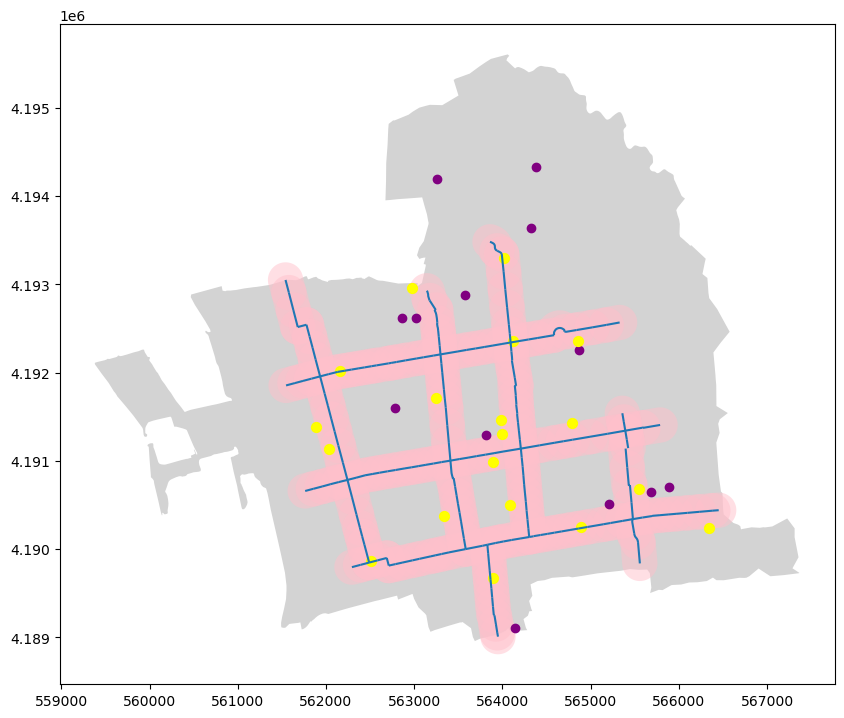

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
# Plot Berkeley city boundary
berkeley_utm10.plot(color='lightgrey', ax=ax)
# Plot buffer
bike_blvds_buf.plot(color='pink', ax=ax, alpha=0.5)
# Plot bicycle boulevards
bike_blvds_utm10.plot(ax=ax)
# Plot Berkeley schools
berkeley_schools.plot(color='purple',ax=ax)
# Plot schools within buffer 
blvd_schools.plot(color='yellow', markersize=50, ax=ax)

If we want to find the shortest distance from one school to the bike boulevards, we can use the `distance` function.

In [43]:
berkeley_schools.distance(bike_blvds_utm10.unary_union)

26      13.848161
27     985.459488
28     309.889446
29     369.402946
30     196.011379
31      15.332395
32      27.250406
33     439.758905
34     107.902846
35     926.216792
36     193.030072
37     181.836256
38     373.736477
39     215.903128
40     184.321307
41     186.446907
406      1.288383
431     94.064527
432    211.477566
433    218.613628
434    186.913116
435    230.212129
436     15.162313
437    188.829602
438    232.764113
439    224.700672
440    173.920971
441     15.892361
442    514.765384
443     92.556921
444     93.426741
516    128.131187
dtype: float64

---

### Challenge 2: Proximity Analysis

Now it's your turn to try out a proximity analysis!

Run the next cell to load BART-system data, reproject it to EPSG: 26910, and subset it to Berkeley.

Then in the following cell, write your own code to find all schools within walking distance (1 km) of a BART station.

As a reminder, let's break this into steps:

1. Buffer your Berkeley BART stations to 1 km (**HINT**: remember your units!).
2. Use the schools' `within` attribute to check whether or not they're within the buffers (**HINT**: don't forget the `unary_union`!).
3. Subset the Berkeley schools using the object returned by your spatial relationship query.
4. As always, plot your results for a good visual check!

---

In [44]:
# Load the BART stations from CSV
bart_stations = pd.read_csv('../data/transportation/bart.csv')
# Convert to a GeoDataFrame
bart_stations_gdf = gpd.GeoDataFrame(bart_stations, 
                                     geometry=gpd.points_from_xy(bart_stations.lon, bart_stations.lat))
# Define its unprojected (EPSG:4326) CRS
bart_stations_gdf.crs = "epsg:4326"
# Transform to UTM Zone 10 N (EPSG:26910)
bart_stations_gdf_utm10 = bart_stations_gdf.to_crs("epsg:26910")
# Subset to Berkeley
berkeley_bart = bart_stations_gdf_utm10[bart_stations_gdf_utm10.within(berkeley_utm10.unary_union)]

In [45]:
# YOUR CODE HERE
# 1. Buffer your Berkeley BART stations to 1 km (HINT: remember your units!).

# Load the BART stations from CSV
bart_stations = pd.read_csv('../data/transportation/bart.csv')
# Convert to a GeoDataFrame
bart_stations_gdf = gpd.GeoDataFrame(bart_stations, 
                                     geometry=gpd.points_from_xy(bart_stations.lon, bart_stations.lat))
# Define its unprojected (EPSG:4326) CRS
bart_stations_gdf.crs = "epsg:4326"
# Transform to UTM Zone 10 N (EPSG:26910)
bart_stations_gdf_utm10 = bart_stations_gdf.to_crs("epsg:26910")
# Subset to Berkeley
berkeley_bart = bart_stations_gdf_utm10[bart_stations_gdf_utm10.within(berkeley_utm10.unary_union)]


In [46]:
# YOUR CODE HERE
# 1a. Buffer your Berkeley BART stations to 1 km (HINT: remember your units!).
# Buffer BART stations to 1 km
bart_buffer = berkeley_bart.buffer(distance=1000)


In [47]:
# YOUR CODE HERE
# 2. Check whether or not they're within the buffers (HINT: don't forget the unary_union!) &
# 3. Subset the Berkeley schools using the object returned by your spatial relationship query.
schools_near_bart = berkeley_schools.within(bart_buffer.unary_union)
bart_schools = berkeley_schools[schools_near_bart]

<Axes: >

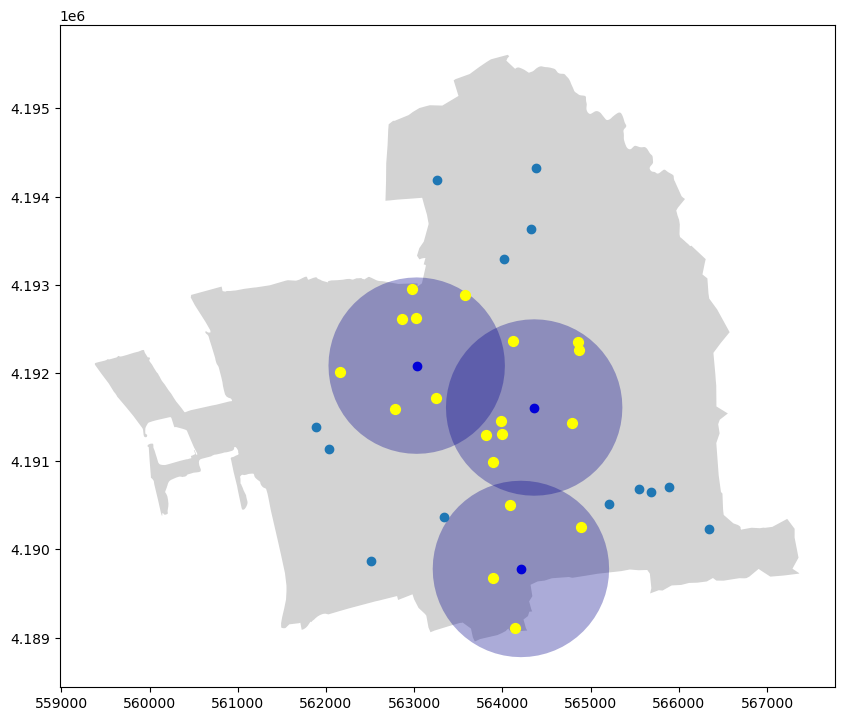

In [51]:
# YOUR CODE HERE
# Plot
fig, ax = plt.subplots(figsize=(10, 10))
# Plot Berkeley boundary
berkeley_utm10.plot(color='lightgrey', ax=ax)
# plot BART stations
berkeley_bart.plot(color='blue', ax=ax)
# add BART buffers
bart_buffer.plot(color='darkblue', ax=ax, alpha=0.33)
# add all Berkeley schools
berkeley_schools.plot(ax=ax)
# add schools near BART
bart_schools.plot(color='yellow', markersize=50, ax=ax)